In [1]:
import torch
import os
from torchvision.transforms import ToTensor,Resize, Normalize,Compose, ToPILImage
from torch.utils.data import Dataset, DataLoader
from tqdm import *
import matplotlib.pyplot as plt

c:\Users\Wen2Tee5\Desktop\Postgraduate\torchPlayGround\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCH = 20
BATCH_SIZE = 32

In [3]:
from PIL import Image
class FlowerDataset(Dataset):

    def __init__(self, root_path, split = 'train', transform = None, device = 'cpu') -> None:
        super(FlowerDataset, self).__init__()
        self.transform = transform
        self.root_path = os.path.join(root_path, split)
        self.class_list = os.listdir(self.root_path)
        self.datas = []
        self.device = device
        for label, class_name in enumerate(self.class_list):
            classPath = os.path.join(self.root_path, class_name)
            img_list = os.listdir(classPath)
            for imgName in img_list:
                imgPath = os.path.join(classPath, imgName)
                self.datas.append((label, imgPath))
    
    def __len__(self):
        return len(self.datas)
    
    def __getitem__(self, index):
        label, imgPath = self.datas[index]
        label = torch.tensor(data=label)
        img = Image.open(imgPath)
        if self.transform is not None:
            img = self.transform(img)
        return label.to(self.device), img.to(self.device)


In [4]:
root_path = '.\\dataset\\flowers_\\'

In [5]:
show_dataset = FlowerDataset(
        root_path=root_path, 
    split='train', 
    transform=Compose(
        [
        Resize(size=(150, 150)),
        ToTensor(),
        ]
        ),
        device=DEVICE
    )

In [6]:
ToImg = ToPILImage()

y = 2
Class is rose
x shape = torch.Size([3, 150, 150])


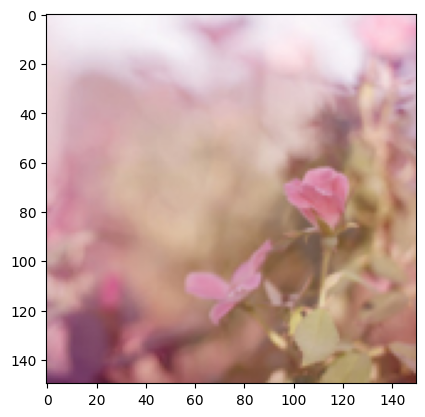

In [7]:
y,x = show_dataset[1599]
print(f'y = {y}')
print(f'Class is {show_dataset.class_list[y.item()]}')
print(f'x shape = {x.shape}')
img = ToImg(x)
plt.imshow(img)
plt.show()

In [8]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [9]:

train_dataset = FlowerDataset(
    root_path=root_path, 
    split='train', 
    transform=Compose([
        Resize(size=(150, 150)),
        ToTensor(),
        Normalize(mean, std)
        ]),
        device=DEVICE
    )
test_dataset = FlowerDataset(
        root_path=root_path, 
        split='test',
        transform=Compose([
        Resize(size=(150, 150)),
        ToTensor(),
        Normalize(mean, std)
        ]),
        device=DEVICE)


In [10]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size = BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size = BATCH_SIZE, shuffle=True)

In [11]:
class Network(torch.nn.Module):

    def __init__(self) -> None:
        super(Network, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear_1 = torch.nn.Linear(3 * 150 * 150, 256)
        self.linear_2 = torch.nn.Linear(256, 128)
        self.linear_3 = torch.nn.Linear(128, 64)
        self.linear_4 = torch.nn.Linear(64, 5)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_1(x)
        x = self.linear_2(x)
        x = self.linear_3(x)
        x = self.linear_4(x)      
        return x

In [12]:
class CNNBased(torch.nn.Module):

    def __init__(self) -> None:
        super(CNNBased, self).__init__()
        self.Conv1 = torch.nn.Conv2d(3, 96, kernel_size=3)
        self.Conv2 = torch.nn.Conv2d(96, 768, kernel_size=3)
        self.maxPool = torch.nn.MaxPool2d(kernel_size=(2, 2))
        self.linear1 = torch.nn.Linear(768 * 36 * 36, 64)
        self.linear2 = torch.nn.Linear(64, 5)
        self.flatten = torch.nn.Flatten()
    
    def forward(self, x):
        x = self.Conv1(x)
        x = self.maxPool(x)
        x = self.Conv2(x)
        x = self.maxPool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [13]:
class CNN1(torch.nn.Module):

    def __init__(self) -> None:
        super(CNN1, self).__init__()
        self.Conv1 = torch.nn.Conv2d(3, 96, kernel_size=3)
        self.Conv2 = torch.nn.Conv2d(96, 768, kernel_size=3)
        self.maxPool = torch.nn.MaxPool2d(kernel_size=(2, 2))
        self.linear1 = torch.nn.Linear(768 * 36 * 36, 64)
        self.linear2 = torch.nn.Linear(64, 5)
        self.flatten = torch.nn.Flatten()
        self.dropout = torch.nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.Conv1(x)
        x = self.dropout(x)
        x = self.maxPool(x)
        x = self.Conv2(x)
        x = self.dropout(x)
        x = self.maxPool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [14]:
def train_step(model, loss_fn, optimizer, dataloader):
    model.train()
    for epoch in range(EPOCH):
        print(f'Current Epoch is {epoch + 1}')
        for y, x in tqdm(dataloader):
            optimizer.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
        print(f'Current loss = {loss.item()}')



def test_step(model, dataloader):
    correct = 0.
    model.eval()
    for y, x in dataloader:
        pred = model(x)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    print(f'Total data {len(dataloader.dataset)}')
    print(f'Correct = {correct}')
    acc = correct/len(dataloader.dataset)
    print(f'The acc is {acc*100.}%')

In [15]:
cnn = CNNBased().to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-3)

In [16]:
train_step(cnn, loss_fn, optimizer, train_dataloader)
test_step(cnn, train_dataloader)
test_step(cnn, test_dataloader)

Current Epoch is 1


100%|██████████| 95/95 [00:13<00:00,  7.12it/s]


Current loss = 5.071476936340332
Current Epoch is 2


100%|██████████| 95/95 [00:09<00:00, 10.20it/s]


Current loss = 1.6869879961013794
Current Epoch is 3


100%|██████████| 95/95 [00:09<00:00, 10.19it/s]


Current loss = 0.38276156783103943
Current Epoch is 4


100%|██████████| 95/95 [00:09<00:00, 10.14it/s]


Current loss = 0.0346314013004303
Current Epoch is 5


100%|██████████| 95/95 [00:09<00:00, 10.35it/s]


Current loss = 0.020692307502031326
Current Epoch is 6


100%|██████████| 95/95 [00:09<00:00, 10.25it/s]


Current loss = 0.004172918852418661
Current Epoch is 7


100%|██████████| 95/95 [00:09<00:00, 10.13it/s]


Current loss = 0.003616389585658908
Current Epoch is 8


100%|██████████| 95/95 [00:09<00:00, 10.17it/s]


Current loss = 0.012945928610861301
Current Epoch is 9


100%|██████████| 95/95 [00:09<00:00, 10.20it/s]


Current loss = 0.0026253839023411274
Current Epoch is 10


100%|██████████| 95/95 [00:09<00:00, 10.15it/s]


Current loss = 0.003144895425066352
Current Epoch is 11


100%|██████████| 95/95 [00:09<00:00, 10.11it/s]


Current loss = 0.002857733052223921
Current Epoch is 12


100%|██████████| 95/95 [00:09<00:00, 10.22it/s]


Current loss = 0.0011129612103104591
Current Epoch is 13


100%|██████████| 95/95 [00:09<00:00,  9.87it/s]


Current loss = 0.0022337608970701694
Current Epoch is 14


100%|██████████| 95/95 [00:09<00:00,  9.83it/s]


Current loss = 0.0007864453364163637
Current Epoch is 15


100%|██████████| 95/95 [00:09<00:00, 10.04it/s]


Current loss = 0.0008592298836447299
Current Epoch is 16


100%|██████████| 95/95 [00:09<00:00, 10.12it/s]


Current loss = 0.0006786963203921914
Current Epoch is 17


100%|██████████| 95/95 [00:09<00:00, 10.07it/s]


Current loss = 0.0005580519791692495
Current Epoch is 18


100%|██████████| 95/95 [00:09<00:00,  9.92it/s]


Current loss = 0.0005182907334528863
Current Epoch is 19


100%|██████████| 95/95 [00:09<00:00,  9.96it/s]


Current loss = 0.0002263789501739666
Current Epoch is 20


100%|██████████| 95/95 [00:09<00:00,  9.96it/s]


Current loss = 0.0009398994734510779
Total data 3027
Correct = 3027.0
The acc is 100.0%
Total data 1296
Correct = 681.0
The acc is 52.54629629629629%


In [17]:
fcnet = Network().to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcnet.parameters(), lr=1e-3)

In [18]:
train_step(fcnet, loss_fn, optimizer, train_dataloader)
test_step(fcnet, train_dataloader)
test_step(fcnet, test_dataloader)

Current Epoch is 1


100%|██████████| 95/95 [00:05<00:00, 18.45it/s]


Current loss = 1.8059953451156616
Current Epoch is 2


100%|██████████| 95/95 [00:05<00:00, 18.38it/s]


Current loss = 1.002455711364746
Current Epoch is 3


100%|██████████| 95/95 [00:05<00:00, 18.51it/s]


Current loss = 1.2699156999588013
Current Epoch is 4


100%|██████████| 95/95 [00:05<00:00, 18.64it/s]


Current loss = 0.8260033130645752
Current Epoch is 5


100%|██████████| 95/95 [00:05<00:00, 18.49it/s]


Current loss = 1.7889662981033325
Current Epoch is 6


100%|██████████| 95/95 [00:05<00:00, 18.60it/s]


Current loss = 0.9801590442657471
Current Epoch is 7


100%|██████████| 95/95 [00:05<00:00, 18.48it/s]


Current loss = 1.6123050451278687
Current Epoch is 8


100%|██████████| 95/95 [00:05<00:00, 18.53it/s]


Current loss = 1.2084665298461914
Current Epoch is 9


100%|██████████| 95/95 [00:05<00:00, 18.47it/s]


Current loss = 0.962486743927002
Current Epoch is 10


100%|██████████| 95/95 [00:05<00:00, 18.30it/s]


Current loss = 1.2404420375823975
Current Epoch is 11


100%|██████████| 95/95 [00:05<00:00, 18.28it/s]


Current loss = 0.8802790641784668
Current Epoch is 12


100%|██████████| 95/95 [00:05<00:00, 18.66it/s]


Current loss = 0.2673070728778839
Current Epoch is 13


100%|██████████| 95/95 [00:05<00:00, 18.26it/s]


Current loss = 0.5209147334098816
Current Epoch is 14


100%|██████████| 95/95 [00:05<00:00, 18.23it/s]


Current loss = 0.7053818702697754
Current Epoch is 15


100%|██████████| 95/95 [00:05<00:00, 18.54it/s]


Current loss = 0.542563259601593
Current Epoch is 16


100%|██████████| 95/95 [00:05<00:00, 18.36it/s]


Current loss = 1.1996856927871704
Current Epoch is 17


100%|██████████| 95/95 [00:05<00:00, 17.56it/s]


Current loss = 1.001929759979248
Current Epoch is 18


100%|██████████| 95/95 [00:05<00:00, 18.20it/s]


Current loss = 0.6828723549842834
Current Epoch is 19


100%|██████████| 95/95 [00:05<00:00, 18.14it/s]


Current loss = 0.5926159024238586
Current Epoch is 20


100%|██████████| 95/95 [00:05<00:00, 18.00it/s]


Current loss = 0.5336156487464905
Total data 3027
Correct = 2587.0
The acc is 85.46415592996365%
Total data 1296
Correct = 457.0
The acc is 35.26234567901235%


In [19]:
cnn_wo = CNN1().to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_wo.parameters(), lr=1e-3)

In [20]:
train_step(cnn_wo, loss_fn, optimizer, train_dataloader)
test_step(cnn_wo, train_dataloader)
test_step(cnn_wo, test_dataloader)

Current Epoch is 1


100%|██████████| 95/95 [00:10<00:00,  9.44it/s]


Current loss = 4.772634506225586
Current Epoch is 2


100%|██████████| 95/95 [00:10<00:00,  9.46it/s]


Current loss = 2.1702518463134766
Current Epoch is 3


100%|██████████| 95/95 [00:10<00:00,  9.29it/s]


Current loss = 2.0856919288635254
Current Epoch is 4


100%|██████████| 95/95 [00:10<00:00,  9.47it/s]


Current loss = 1.2010136842727661
Current Epoch is 5


100%|██████████| 95/95 [00:09<00:00,  9.50it/s]


Current loss = 0.4895259439945221
Current Epoch is 6


100%|██████████| 95/95 [00:10<00:00,  9.50it/s]


Current loss = 0.1744910627603531
Current Epoch is 7


100%|██████████| 95/95 [00:10<00:00,  9.44it/s]


Current loss = 1.3445442914962769
Current Epoch is 8


100%|██████████| 95/95 [00:10<00:00,  9.41it/s]


Current loss = 0.04590665549039841
Current Epoch is 9


100%|██████████| 95/95 [00:10<00:00,  9.40it/s]


Current loss = 0.46828797459602356
Current Epoch is 10


100%|██████████| 95/95 [00:10<00:00,  9.34it/s]


Current loss = 0.24303694069385529
Current Epoch is 11


100%|██████████| 95/95 [00:10<00:00,  9.43it/s]


Current loss = 0.4169774651527405
Current Epoch is 12


100%|██████████| 95/95 [00:10<00:00,  9.35it/s]


Current loss = 0.36166486144065857
Current Epoch is 13


100%|██████████| 95/95 [00:10<00:00,  9.40it/s]


Current loss = 0.005962633527815342
Current Epoch is 14


100%|██████████| 95/95 [00:10<00:00,  9.33it/s]


Current loss = 0.47917482256889343
Current Epoch is 15


100%|██████████| 95/95 [00:10<00:00,  9.37it/s]


Current loss = 0.07121548801660538
Current Epoch is 16


100%|██████████| 95/95 [00:10<00:00,  9.42it/s]


Current loss = 0.1719471514225006
Current Epoch is 17


100%|██████████| 95/95 [00:10<00:00,  9.42it/s]


Current loss = 0.00032020750222727656
Current Epoch is 18


100%|██████████| 95/95 [00:10<00:00,  9.38it/s]


Current loss = 0.06795870512723923
Current Epoch is 19


100%|██████████| 95/95 [00:10<00:00,  9.22it/s]


Current loss = 0.320436954498291
Current Epoch is 20


100%|██████████| 95/95 [00:10<00:00,  9.29it/s]


Current loss = 0.010410450398921967
Total data 3027
Correct = 1867.0
The acc is 61.67822926990419%
Total data 1296
Correct = 552.0
The acc is 42.592592592592595%


In [21]:
class one_layerCNN(torch.nn.Module):

    def __init__(self) -> None:
        super(one_layerCNN, self).__init__()
        self.conv = torch.nn.Conv2d(3, 9, kernel_size=3)
        self.linear = torch.nn.Linear(74*74*9, 5)
        self.maxpool = torch.nn.MaxPool2d(2, 2)
        self.flatten = torch.nn.Flatten()
        self.dropout = torch.nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.dropout(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.linear(x)
        x = self.dropout(x)
        return x

In [22]:
temp = one_layerCNN().to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(temp.parameters(), lr=1e-3)

In [23]:
train_step(temp, loss_fn, optimizer, train_dataloader)
test_step(temp, train_dataloader)
test_step(temp, test_dataloader)

Current Epoch is 1


100%|██████████| 95/95 [00:05<00:00, 17.88it/s]


Current loss = 3.912414073944092
Current Epoch is 2


100%|██████████| 95/95 [00:05<00:00, 18.01it/s]


Current loss = 1.7526673078536987
Current Epoch is 3


100%|██████████| 95/95 [00:05<00:00, 17.90it/s]


Current loss = 1.6796696186065674
Current Epoch is 4


100%|██████████| 95/95 [00:05<00:00, 18.05it/s]


Current loss = 1.103293538093567
Current Epoch is 5


100%|██████████| 95/95 [00:05<00:00, 18.09it/s]


Current loss = 0.838268518447876
Current Epoch is 6


100%|██████████| 95/95 [00:05<00:00, 17.98it/s]


Current loss = 0.9112482666969299
Current Epoch is 7


100%|██████████| 95/95 [00:05<00:00, 17.77it/s]


Current loss = 0.9625380635261536
Current Epoch is 8


100%|██████████| 95/95 [00:05<00:00, 18.17it/s]


Current loss = 0.7804428935050964
Current Epoch is 9


100%|██████████| 95/95 [00:05<00:00, 18.27it/s]


Current loss = 1.0227925777435303
Current Epoch is 10


100%|██████████| 95/95 [00:05<00:00, 18.09it/s]


Current loss = 0.5977725386619568
Current Epoch is 11


100%|██████████| 95/95 [00:05<00:00, 18.23it/s]


Current loss = 0.7208164930343628
Current Epoch is 12


100%|██████████| 95/95 [00:05<00:00, 18.33it/s]


Current loss = 0.7074167132377625
Current Epoch is 13


100%|██████████| 95/95 [00:05<00:00, 18.33it/s]


Current loss = 0.7796699404716492
Current Epoch is 14


100%|██████████| 95/95 [00:05<00:00, 18.20it/s]


Current loss = 0.23297926783561707
Current Epoch is 15


100%|██████████| 95/95 [00:05<00:00, 18.33it/s]


Current loss = 0.7205383777618408
Current Epoch is 16


100%|██████████| 95/95 [00:05<00:00, 17.94it/s]


Current loss = 0.6613836884498596
Current Epoch is 17


100%|██████████| 95/95 [00:05<00:00, 17.89it/s]


Current loss = 0.7922653555870056
Current Epoch is 18


100%|██████████| 95/95 [00:05<00:00, 18.12it/s]


Current loss = 0.581925094127655
Current Epoch is 19


100%|██████████| 95/95 [00:05<00:00, 18.33it/s]


Current loss = 0.5547512769699097
Current Epoch is 20


100%|██████████| 95/95 [00:05<00:00, 18.34it/s]


Current loss = 0.46035104990005493
Total data 3027
Correct = 1877.0
The acc is 62.00858936240502%
Total data 1296
Correct = 496.0
The acc is 38.2716049382716%
